# Our first RNN model (The baseline model)

For **Visualization and Recommendation system teams**

Please first install following stuff to run this notebook:

1) Pytorch

pip3 install torch torchvision

2) TorchText

pip3 install torchtext

3) Then English model

sudo python3 -m spacy download en
pip3 install transformers


## Data preprocessing

Using TorchText is very helpful in data preprocessing of this dataset.

In [1]:
import os
import glob
import io
import torch
from torchtext import data
#import spacy
SEED = 1234
#import en_core_web_sm
#spacy = en_core_web_sm.load()

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#nlp = spacy.load("en_core_web_sm")
#doc = nlp("This is a sentence.")

TEXT = data.Field(tokenize = 'spacy')
LABEL = data.LabelField(dtype = torch.float)
FILENAME = data.Field()

print (TEXT)
print("Done")

Done


**Next I wrote custom class to include additional stuff for IMDB dataset.**

In [3]:
class IMDB(data.Dataset):

    urls = ['./aclImdb_v1.tar.gz'] #/home/usman/Downloads
    name = 'imdb'
    dirname = 'aclImdb'

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    def __init__(self, path, text_field, label_field, **kwargs):
        """Create an IMDB dataset instance given a path and fields.
        Arguments:
            path: Path to the dataset's highest level directory
            text_field: The field that will be used for text data.
            label_field: The field that will be used for label data.
            Remaining keyword arguments: Passed to the constructor of
                data.Dataset.
        """
        #print(text_field)
        path=path.replace('data/imdb','')
        fname_data = data.RawField()
        
        fields = [('text', text_field), ('label', label_field), ('aname', fname_data)]
        examples = []
        #dddddddddd
        for label in ['pos', 'neg']:
            for fname in glob.iglob(os.path.join(path, label, '*.txt')):
                with io.open(fname, 'r', encoding="utf-8") as f:
                    text = f.readline()
                #print(fname)
                #print(text)
                
                examples.append(data.Example.fromlist([text, label,fname.split('aclImdb')[1]], fields))
                #print(examples[0].fname)
                #mmmmmmmmmmmmm

        super(IMDB, self).__init__(examples, fields, **kwargs)

    @classmethod
    def splits(cls, text_field, label_field, root='.data',
               train='train', test='test', **kwargs):
        """Create dataset objects for splits of the IMDB dataset.
        Arguments:
            text_field: The field that will be used for the sentence.
            label_field: The field that will be used for label data.
            root: Root dataset storage directory. Default is '.data'.
            train: The directory that contains the training examples
            test: The directory that contains the test examples
            Remaining keyword arguments: Passed to the splits method of
                Dataset.
        """
        
        return super(IMDB, cls).splits(
            root=root, text_field=text_field, label_field=label_field,
            train=train, validation=None, test=test, **kwargs)

    @classmethod
    def iters(cls, batch_size=32, device=0, root='.data', vectors=None, **kwargs):
        """Create iterator objects for splits of the IMDB dataset.
        Arguments:
            batch_size: Batch_size
            device: Device to create batches on. Use - 1 for CPU and None for
                the currently active GPU device.
            root: The root directory that contains the imdb dataset subdirectory
            vectors: one of the available pretrained vectors or a list with each
                element one of the available pretrained vectors (see Vocab.load_vectors)
            Remaining keyword arguments: Passed to the splits method.
        """
        TEXT = data.Field()
        LABEL = data.Field(sequential=False)
        
        #usman123
        train, test = cls.splits(TEXT, LABEL, root=root, **kwargs)

        TEXT.build_vocab(train, vectors=vectors)
        LABEL.build_vocab(train)
        #yyyyyyyy
        return data.BucketIterator.splits(
            (train, test), batch_size=batch_size, device=device)
    
train_data, test_data = IMDB.splits(TEXT, LABEL)

print('Total training examples:', len(train_data))
print('Total testing examples:', len(test_data))
print(vars(test_data.examples[0]))

Total training examples: 25000
Total testing examples: 25000
{'aname': '/test/pos/127_10.txt', 'label': 'pos', 'text': ['Previous', 'reviewer', 'Claudio', 'Carvalho', 'gave', 'a', 'much', 'better', 'recap', 'of', 'the', 'film', "'s", 'plot', 'details', 'than', 'I', 'could', '.', 'What', 'I', 'recall', 'mostly', 'is', 'that', 'it', 'was', 'just', 'so', 'beautiful', ',', 'in', 'every', 'sense', '-', 'emotionally', ',', 'visually', ',', 'editorially', '-', 'just', 'gorgeous.<br', '/><br', '/>If', 'you', 'like', 'movies', 'that', 'are', 'wonderful', 'to', 'look', 'at', ',', 'and', 'also', 'have', 'emotional', 'content', 'to', 'which', 'that', 'beauty', 'is', 'relevant', ',', 'I', 'think', 'you', 'will', 'be', 'glad', 'to', 'have', 'seen', 'this', 'extraordinary', 'and', 'unusual', 'work', 'of', 'art.<br', '/><br', '/>On', 'a', 'scale', 'of', '1', 'to', '10', ',', 'I', "'d", 'give', 'it', 'about', 'an', '8.75', '.', 'The', 'only', 'reason', 'I', 'shy', 'away', 'from', '9', 'is', 'that', 'it

We can see how many examples are in each split by checking their length.

One example to help you access the training and testing objects.

For **Viualization and Recommendation system Teams**:
you can use these objects for your working

Splitting training data into 75/25 train/valid split.

For **Recommendation system Teams**:
you can use these objects for your working

In [4]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

print('Total training examples:', len(train_data))
print('Total validation examples: ',len(valid_data))
print('Total testing examples: ',len(test_data))

Total training examples: 17500
Total validation examples:  7500
Total testing examples:  25000


**Now preparing data for the baseline NLP model**

In [5]:
MAX_VOCAB_SIZE = 25000
TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)
#FILENAME.build_vocab(train_data)

In [6]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(vars(train_data.examples[0]))
#usman:check iters
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)
print(vars(test_iterator))

{'aname': '/train/neg/2026_2.txt', 'label': 'neg', 'text': ['There', 'was', 'such', 'a', 'hype', 'about', 'a', 'game', 'show', 'with', 'Bill', 'Shatner', '...', 'and', 'especially', 'right', 'in', 'the', 'wake', 'of', 'Deal', 'or', 'No', 'Deal', 'and', '1', 'vs', '100', '.', 'So', ',', 'of', 'course', 'everyone', 'had', 'to', 'tune', 'in', 'to', 'see', 'what', 'all', 'the', 'fuss', 'was', 'about', 'on', 'the', 'new', 'game', 'show', '.', 'What', 'a', 'disappointment', '!', 'As', 'Ben', 'Stein', 'so', 'stoically', 'and', 'nasally', 'says', ',', '"', 'wooww".<br', '/><br', '/>The', 'only', 'thing', 'likable', 'about', 'this', 'show', 'was', 'the', 'fact', 'that', 'you', 'knew', 'it', 'would', 'eventually', 'be', 'over', '.', 'Sitting', 'through', 'a', 'full', 'hour', 'of', 'it', 'was', 'like', 'going', 'to', 'the', 'dentist', '...', 'you', 'find', 'yourself', 'looking', 'at', 'the', 'clock', 'in', 'what', 'you', 'think', 'are', '10', 'minute', 'intervals', ',', 'only', 'to', 'find', 'out

**The baseline Model definition**

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
       
        embedded = self.embedding(text)
        
        output, hidden = self.rnn(embedded)
 
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))
    
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

Training process

In [8]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)

#util funtions
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    #batch = next(iterator.__iter__())
    #print(batch.text)
    #print(batch.aname)
    #print(batch.text)
    #usman: check eval
    
    for batch in iterator:
            
        optimizer.zero_grad()
                
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
#        train_loss_values.append(loss.item())
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [10]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    #sssssssss
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])
            #sssdsdssd
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            #valid_loss_values.append(loss.item())
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

from sklearn.metrics import precision_score,recall_score
precision=[]

def evaluate_test(model, iterator, criterion):
    
    
    import csv

    epoch_loss = 0
    epoch_acc = 0
    epoch_prec = 0
    epoch_recall = 0
    
    g=0
    model.eval()
    #sssssssss
    with torch.no_grad():
    
        for batch in iterator:
            g=g+1
            predictions = model(batch.text).squeeze(1)
            rounded_preds_us = torch.round(torch.sigmoid(predictions))

            epoch_prec+=precision_score(batch.label, rounded_preds_us, average='weighted')  
            epoch_recall+=recall_score(batch.label, rounded_preds_us, average='weighted')  

            #precision_score(y_true, y_pred, average='micro')  

            #precision_score(y_true, y_pred, average='weighted')
            
            #print(predictions)
            #print(batch.text.shape)
            #print(TEXT.vocab.itos[11])
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)
            #print(epoch_prec)
            #print(rounded_preds_us)
            #usman:check valid later
            
            with open('sentiment_results_the_baseline_reviews.csv', mode='a') as sent_file:
                file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                
                for x in range(0,len(predictions)):
                    file_writer.writerow([batch.aname[x], rounded_preds_us[x].item(),batch.label[x].item()])

            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    #print('g=',str(g)) 
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_prec / len(iterator), epoch_recall / len(iterator)

**Training**

In [17]:
N_EPOCHS = 50

train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)
    
    train_acc_values.append(train_acc)
    valid_acc_values.append(valid_acc)
      
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'baselineModelReviews.pt')
    
    print('Epoch: ',str(epoch+1),' | Epoch Time:',str(epoch_mins),'m ',str(epoch_secs),'s')
    print('\tTrain Loss: ',str(train_loss),' | Train Acc: ',str(train_acc*100),'%')
    print('\t Val. Loss: ',str(valid_loss),' |  Val. Acc: ',str(valid_acc*100),'%')

Epoch:  1  | Epoch Time: 0 m  26 s
	Train Loss:  0.6932685001053079  | Train Acc:  49.88594890510949 %
	 Val. Loss:  0.6970345135462486  |  Val. Acc:  50.11034607887268 %
Epoch:  2  | Epoch Time: 0 m  27 s
	Train Loss:  0.693335825944469  | Train Acc:  49.79959593637146 %
	 Val. Loss:  0.6971065225237507  |  Val. Acc:  50.09710455344896 %
Epoch:  3  | Epoch Time: 0 m  27 s
	Train Loss:  0.6932379464163397  | Train Acc:  49.9209789029003 %
	 Val. Loss:  0.6970540118419518  |  Val. Acc:  50.216278282262515 %
Epoch:  4  | Epoch Time: 0 m  25 s
	Train Loss:  0.6930738313354715  | Train Acc:  50.16374479245095 %
	 Val. Loss:  0.6967563548330533  |  Val. Acc:  49.752824892432 %
Epoch:  5  | Epoch Time: 0 m  26 s
	Train Loss:  0.6932005416737855  | Train Acc:  50.205291970802925 %
	 Val. Loss:  0.6974586384781336  |  Val. Acc:  50.54731639259953 %
Epoch:  6  | Epoch Time: 0 m  26 s
	Train Loss:  0.6933436015226545  | Train Acc:  49.87291450048016 %
	 Val. Loss:  0.6970643633503025  |  Val. Ac

Epoch:  49  | Epoch Time: 0 m  26 s
	Train Loss:  0.6931229096694584  | Train Acc:  50.60202686020928 %
	 Val. Loss:  0.6978629090018191  |  Val. Acc:  49.96468929921166 %
Epoch:  50  | Epoch Time: 0 m  25 s
	Train Loss:  0.6931883866769554  | Train Acc:  49.90224192177292 %
	 Val. Loss:  0.6975863914368516  |  Val. Acc:  50.28248590938116 %


Once we have trainned model, now evalting on the testing 25,000 reviews.

In [18]:
print(len(train_loss_values))
print(len(valid_loss_values))
print(train_loss_values)
print(valid_loss_values)

print(len(train_acc_values))
print(len(valid_acc_values))
print(train_acc_values)
print(valid_acc_values)

with open('the_baseline_performance.txt', 'w') as filehandle:
    tLoss=','.join([str(x) for x in train_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_loss_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in train_acc_values])
    filehandle.write(tLoss+"\n")
    tLoss=','.join([str(x) for x in valid_acc_values])
    filehandle.write(tLoss)
    
    
    #for listitem in train_loss_values:
     #   filehandle.write(listitem)




50
50
[0.6932685001053079, 0.693335825944469, 0.6932379464163397, 0.6930738313354715, 0.6932005416737855, 0.6933436015226545, 0.6931507463437797, 0.6932443987279042, 0.6932891180915554, 0.6932776302751833, 0.6930482961835652, 0.6932139588098456, 0.6932408363714705, 0.6931355382404188, 0.693216686048647, 0.6932266402418596, 0.6931942237989746, 0.6931597720967592, 0.6932117342948914, 0.6932083503173215, 0.6931010293264459, 0.6932378824609909, 0.6931981703225714, 0.6931675159148056, 0.6931673945301641, 0.6932140878082191, 0.6931452026767452, 0.6931629633381419, 0.6932168998857484, 0.6931523561042591, 0.6933178829885748, 0.693187495000171, 0.6932414008753143, 0.6930831098643533, 0.693139779089141, 0.6932684661698167, 0.6931507809318765, 0.6931902048361562, 0.6930443511827149, 0.6932051971445988, 0.6932126137897046, 0.6931768662303034, 0.6930964010475326, 0.6932664161180928, 0.6931444702357271, 0.693195153544419, 0.6932244748964796, 0.6931201326150964, 0.6931229096694584, 0.6931883866769554

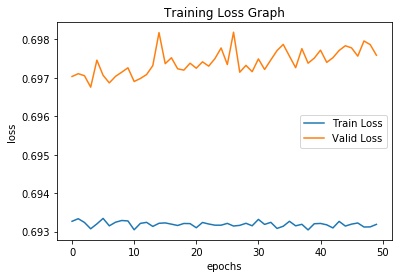

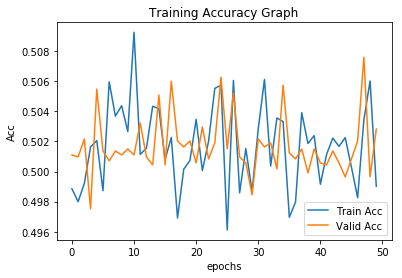

In [19]:
from matplotlib import pyplot as plt


train_loss_values=[]
valid_loss_values=[]

train_acc_values=[]
valid_acc_values=[]


# open file and read the content in a list
with open('the_baseline_performance.txt', 'r') as filehandle:
    filecontents = filehandle.readlines()
    
    train_loss_values=[float(i) for i in filecontents[0].split(',')]
    valid_loss_values=[float(i) for i in filecontents[1].split(',')]
    train_acc_values=[float(i) for i in filecontents[2].split(',')]
    valid_acc_values=[float(i) for i in filecontents[3].split(',')]

plt.title('Training Loss Graph')
plt.plot(train_loss_values,label='Train Loss')
plt.plot(valid_loss_values,label='Valid Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.title('Training Accuracy Graph')
plt.plot(train_acc_values,label='Train Acc')
plt.plot(valid_acc_values,label='Valid Acc')
plt.xlabel('epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


In [20]:
model.load_state_dict(torch.load('baselineModelReviews.pt'))

import csv

with open('sentiment_results_the_baseline_reviews.csv', mode='w') as sent_file:
    file_writer = csv.writer(sent_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    file_writer.writerow(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'])                
    




test_loss, test_acc, test_prec, test_recall = evaluate_test(model, test_iterator, criterion)

print('Test Loss: ',str(test_loss),' | Acc:',str(test_acc*100),'% ', 'Precision: ',str(test_prec), 'Recall: ',str(test_recall))
print('Results are also written in the csv file')

/scratch/usajid/python352/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/usajid/python352/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Test Loss:  0.7091466353067657  | Acc: 46.37627877542735 %  Precision:  0.4746828084682134 Recall:  0.4637627877237852
Results are also written in the csv file


**Now generating word cloud.**

Index(['Review File Path', 'Our Prediction', 'Ground Truth (1: pos, 0:neg)'], dtype='object')


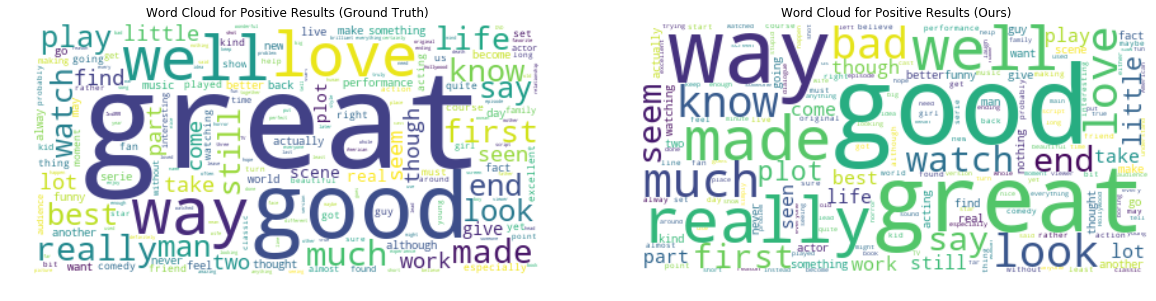

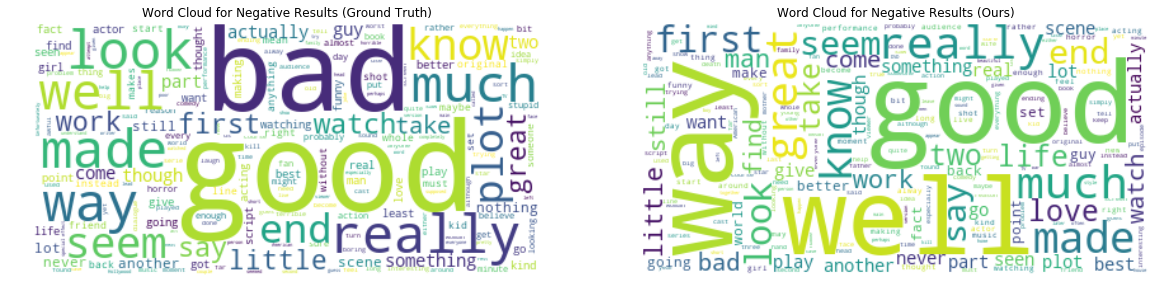

In [27]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd

my_directory='./aclImdb'
stpwords = set(STOPWORDS)# removing the stop words.
stpwords.update(['movie','movies','film','films',
                 'actor','actress','cinema','even','scene','will','people','many','now','quot','today',
                 'story','br','role','dramas','drama','one','make','see','time','show','think','thing',
                 'characters','character','director'])# removing the words that are of no importance.

model_df = pd.read_csv ("./sentiment_results_the_baseline_reviews.csv")

allTextPos=""
allTextPosGT=""

print(model_df.columns)

for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==1.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPosGT=allTextPosGT+" "+data

for ind in model_df[model_df['Our Prediction']==1.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextPos=allTextPos+" "+data

        

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPosGT)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextPos)

# Display the generated image:
plt.title('Word Cloud for Positive Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




allTextNeg=""
allTextNegGT=""

for ind in model_df[model_df['Our Prediction']==0.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         allTextNeg=allTextNeg+" "+data


for ind in model_df[model_df['Ground Truth (1: pos, 0:neg)']==0.0].index: 
     path=my_directory+model_df['Review File Path'][ind]
     #print(path)
     with open(path, 'r') as file:
         data = file.read()##.replace('\n', '')
         #print(data)
         allTextNegGT=allTextNegGT+" "+data


plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNegGT)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ground Truth)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
#plt.show()


plt.subplot(1, 2, 2)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stpwords,background_color="white").generate(allTextNeg)

# Display the generated image:
plt.title('Word Cloud for Negative Results (Ours)')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()




## References

[1] https://arxiv.org/pdf/1607.01759.pdf

[2] https://arxiv.org/pdf/1408.5882.pdf

[3] https://ai.stanford.edu/~amaas/data/sentiment/

[4] https://github.com/bentrevett/pytorch-sentiment-analysis

[5] https://github.com/tlkh/text-emotion-classification